In [1]:
#随机森林
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
import matplotlib.pyplot as plt
from sklearn import metrics
import collections

import joblib

In [2]:
# filepath：数据集路径，window：序列窗口长度，data_type：训练集or测试集,Merry数据
def load_dataset(filepath, window, data_type): 
    if os.path.exists(filepath) == False:
        print('Error: file %s does not exist.' % file)
        sys.exit(1)
    if window % 2 == 0:
        print('Error: the  window should be an odd number' + '\n\n')
        return 0
    train_data = shuffle(pd.read_csv(filepath))
    split = int((window-1)/2)   # 序列中心位置左右残基的长度
    sequence = []
    for i in range(train_data.shape[0]):
        lineData = train_data.iloc[i]
        seq = []
        seq.append(lineData[0])
        if len(lineData[2]) != 41:
            print('Error: the  window should be 41' + '\n\n')
            return 0
        seq.append(lineData[2][20-split:20+split+1])
        seq.append(lineData[3])
        seq.append(data_type)
        sequence.append(seq)
    return sequence

In [3]:
def EAAC(fastas, window=5):
    if window < 1:
        print('Error: the sliding window should be greater than zero' + '\n\n')
        return 0
    AA = 'ACDEFGHIKLMNPQRSTVWY'
    encodings = []
    header = ['#', 'label']
    for w in range(1, len(fastas[0][1]) - window + 2):
        for aa in AA:
            header.append('SW.' + str(w) + '.' + aa)
    encodings.append(header)

    for i in fastas:
        name, sequence, label = i[0], i[1], i[2]
        code = [name, label]
        for j in range(len(sequence)):
            if j < len(sequence) and j + window <= len(sequence):
                count = collections.Counter(sequence[j:j + window])
                for key in count:
                    count[key] = count[key] / len(sequence[j:j + window])
                for aa in AA:
                    code.append(count[aa])
        encodings.append(code)
    return encodings

In [4]:
def train_test_load(train_encodings,test_encodings) :
    train_encodings = np.delete(np.array(train_encodings),0,axis=0)
    test_encodings = np.delete(np.array(test_encodings),0,axis=0)
    x_train = np.delete(train_encodings,[0,1],axis=1).astype(np.float)
    x_test = np.delete(test_encodings,[0,1],axis=1).astype(np.float)
    y_train = train_encodings[:,1].astype(int)
    y_test = test_encodings[:,1].astype(int)
    return x_train,y_train,x_test,y_test

In [5]:
import os
from sklearn.utils import shuffle
import pandas as pd
train_path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集\train.csv'
test_path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集\test.csv'
window = 41 # 序列窗口长度

In [6]:
# 读取训练、测试数据
train_data = load_dataset(train_path,window,'train')
test_data = load_dataset(test_path,window,'test')

In [7]:
train_encodings = EAAC(train_data)
test_encodings = EAAC(test_data)

In [8]:
x_train,y_train,x_test,y_test = train_test_load(train_encodings,test_encodings)

In [9]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\RF_EAAC')

In [10]:
out = os.getcwd() + '\\'

In [64]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    #rf=RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=None,min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False,class_weight=None,ccp_alpha=0.0, max_samples=None) # class_weight='balanced'
    #rf=RandomForestClassifier(n_estimators=150, criterion='gini', bootstrap=True, oob_score=True) # class_weight='balanced'
    rf=RandomForestClassifier(n_estimators=150, bootstrap=True, oob_score=True, n_jobs=15)
    scores1 = rf.fit(tr_x,tr_y).predict_proba(val_x)[:,1]#进行模型的训练
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1)
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    joblib.dump(rf, '%s_%d.m' % (out, n_fold))
    #rf.save(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\RF_EAAC\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\RF_EAAC\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = rf.predict_proba(x_test)[:,1]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\RF_EAAC\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\RF_EAAC\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

1
2
3
4
5
6
7
8
9
10


In [65]:
#遍历表格求初始里程
#交叉验证
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\RF_EAAC\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [66]:
roc_auc_list_val

[0.7456210830789008,
 0.7515776020448918,
 0.7181422924901186,
 0.7451499118165784,
 0.7748516915183581,
 0.813897257016014,
 0.6767568850902185,
 0.7236904761904762,
 0.6777415247493238,
 0.7278745085452942]

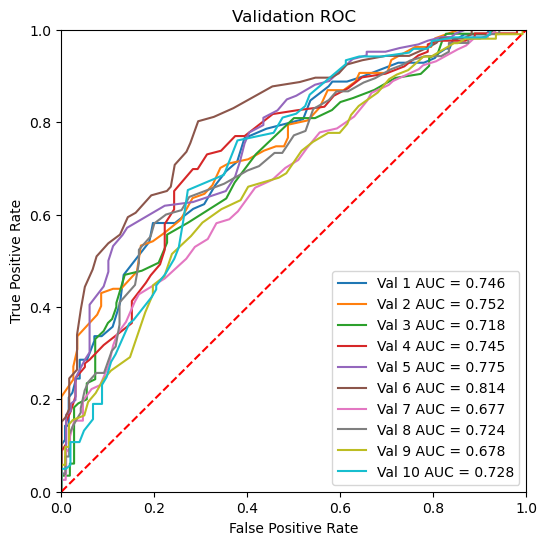

In [67]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('RF_EAAC_val.png')
plt.show()

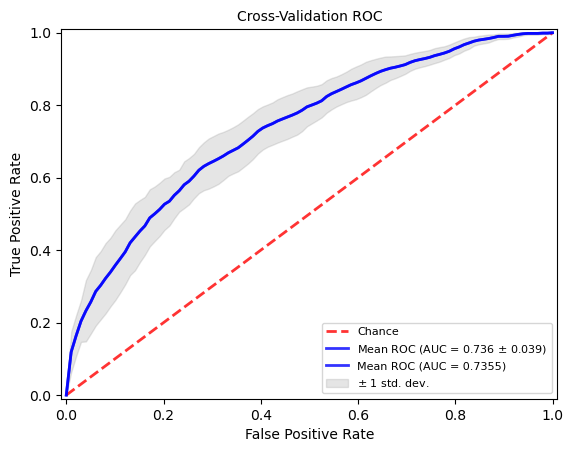

In [68]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('RF_EAAC_val_mean.png')
plt.show()

In [69]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [47]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [48]:
my_calculate_metrics_list_val

[{'SN': 0.7037037037037037,
  'SP': 0.6581196581196581,
  'ACC': 0.68,
  'MCC': 0.36170887887101866,
  'Recall': 0.7037037037037037,
  'Precision': 0.6551724137931034,
  'F1-score': 0.6785714285714286,
  'Cutoff': 0.5},
 {'SN': 0.7155963302752294,
  'SP': 0.591304347826087,
  'ACC': 0.6517857142857143,
  'MCC': 0.30887831066694493,
  'Recall': 0.7155963302752294,
  'Precision': 0.624,
  'F1-score': 0.6666666666666666,
  'Cutoff': 0.5},
 {'SN': 0.6721311475409836,
  'SP': 0.5922330097087378,
  'ACC': 0.6355555555555555,
  'MCC': 0.26480706691462214,
  'Recall': 0.6721311475409836,
  'Precision': 0.6612903225806451,
  'F1-score': 0.6666666666666666,
  'Cutoff': 0.5},
 {'SN': 0.6324786324786325,
  'SP': 0.7129629629629629,
  'ACC': 0.6711111111111111,
  'MCC': 0.34593473144632125,
  'Recall': 0.6324786324786325,
  'Precision': 0.7047619047619048,
  'F1-score': 0.6666666666666666,
  'Cutoff': 0.5},
 {'SN': 0.6106194690265486,
  'SP': 0.6428571428571429,
  'ACC': 0.6266666666666667,
  'MCC'

In [49]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.703704,0.658120,0.680000,0.361709,0.703704,0.655172,0.678571,0.5
1,0.715596,0.591304,0.651786,0.308878,0.715596,0.624000,0.666667,0.5
2,0.672131,0.592233,0.635556,0.264807,0.672131,0.661290,0.666667,0.5
3,0.632479,0.712963,0.671111,0.345935,0.632479,0.704762,0.666667,0.5
4,0.610619,0.642857,0.626667,0.253597,0.610619,0.633028,0.621622,0.5
5,0.690000,0.656000,0.671111,0.343861,0.690000,0.616071,0.650943,0.5
6,0.747748,0.631579,0.688889,0.381656,0.747748,0.664000,0.703390,0.5
7,0.628319,0.616071,0.622222,0.244409,0.628319,0.622807,0.625551,0.5
8,0.642276,0.578431,0.613333,0.220532,0.642276,0.647541,0.644898,0.5
9,0.638889,0.655172,0.647321,0.293979,0.638889,0.633028,0.635945,0.5


In [50]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.703704,0.658120,0.680000,0.361709,0.703704,0.655172,0.678571,0.5
1,0.715596,0.591304,0.651786,0.308878,0.715596,0.624000,0.666667,0.5
2,0.672131,0.592233,0.635556,0.264807,0.672131,0.661290,0.666667,0.5
3,0.632479,0.712963,0.671111,0.345935,0.632479,0.704762,0.666667,0.5
4,0.610619,0.642857,0.626667,0.253597,0.610619,0.633028,0.621622,0.5
5,0.690000,0.656000,0.671111,0.343861,0.690000,0.616071,0.650943,0.5
6,0.747748,0.631579,0.688889,0.381656,0.747748,0.664000,0.703390,0.5
7,0.628319,0.616071,0.622222,0.244409,0.628319,0.622807,0.625551,0.5
8,0.642276,0.578431,0.613333,0.220532,0.642276,0.647541,0.644898,0.5
9,0.638889,0.655172,0.647321,0.293979,0.638889,0.633028,0.635945,0.5


In [51]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\RF_EAAC\result\RF_EAAC_performance_val.csv',encoding='utf-8')

独立测试

In [70]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\RF_EAAC\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [72]:
roc_auc_list_indep

[0.733219068877551,
 0.7525510204081632,
 0.7460140306122449,
 0.7306281887755103,
 0.7609614158163265,
 0.7752311862244898,
 0.744060905612245,
 0.7071109693877551,
 0.741390306122449,
 0.7681361607142857]

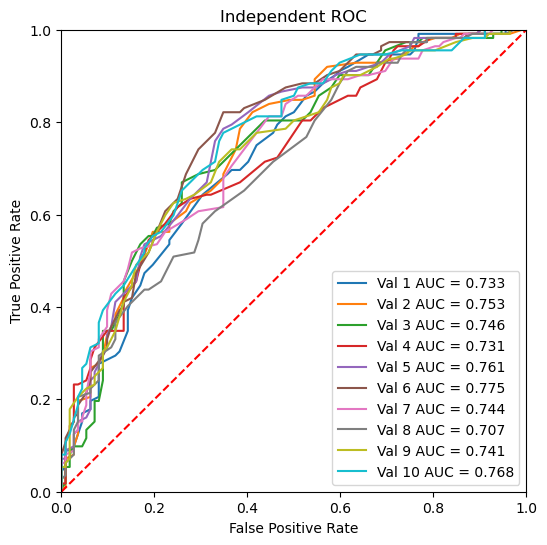

In [73]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('RF_EAAC_indep.png')
plt.show()

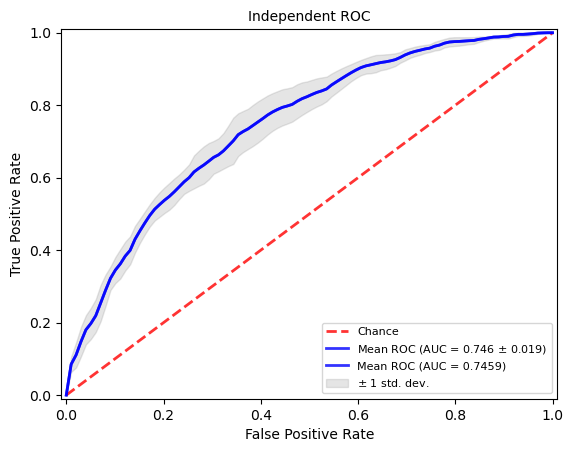

In [74]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('RF_EAAC_indep_mean.png')
plt.show()

In [75]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [76]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [77]:
my_calculate_metrics_list_indep

[{'SN': 0.6964285714285714,
  'SP': 0.6160714285714286,
  'ACC': 0.65625,
  'MCC': 0.3135138612340933,
  'Recall': 0.6964285714285714,
  'Precision': 0.6446280991735537,
  'F1-score': 0.6695278969957081,
  'Cutoff': 0.5},
 {'SN': 0.6785714285714286,
  'SP': 0.6517857142857143,
  'ACC': 0.6651785714285714,
  'MCC': 0.3304757180782423,
  'Recall': 0.6785714285714286,
  'Precision': 0.6608695652173913,
  'F1-score': 0.6696035242290749,
  'Cutoff': 0.5},
 {'SN': 0.6696428571428571,
  'SP': 0.7410714285714286,
  'ACC': 0.7053571428571429,
  'MCC': 0.4117660525726739,
  'Recall': 0.6696428571428571,
  'Precision': 0.7211538461538461,
  'F1-score': 0.6944444444444444,
  'Cutoff': 0.5},
 {'SN': 0.6339285714285714,
  'SP': 0.7232142857142857,
  'ACC': 0.6785714285714286,
  'MCC': 0.3585749859822395,
  'Recall': 0.6339285714285714,
  'Precision': 0.696078431372549,
  'F1-score': 0.6635514018691588,
  'Cutoff': 0.5},
 {'SN': 0.6696428571428571,
  'SP': 0.6875,
  'ACC': 0.6785714285714286,
  'MCC'

In [78]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.696429,0.616071,0.656250,0.313514,0.696429,0.644628,0.669528,0.5
1,0.678571,0.651786,0.665179,0.330476,0.678571,0.660870,0.669604,0.5
2,0.669643,0.741071,0.705357,0.411766,0.669643,0.721154,0.694444,0.5
3,0.633929,0.723214,0.678571,0.358575,0.633929,0.696078,0.663551,0.5
4,0.669643,0.687500,0.678571,0.357200,0.669643,0.681818,0.675676,0.5
5,0.687500,0.732143,0.709821,0.420062,0.687500,0.719626,0.703196,0.5
6,0.616071,0.651786,0.633929,0.268028,0.616071,0.638889,0.627273,0.5
7,0.651786,0.607143,0.629464,0.259187,0.651786,0.623932,0.637555,0.5
8,0.669643,0.678571,0.674107,0.348228,0.669643,0.675676,0.672646,0.5
9,0.696429,0.696429,0.696429,0.392857,0.696429,0.696429,0.696429,0.5


In [79]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.696429,0.616071,0.656250,0.313514,0.696429,0.644628,0.669528,0.5
1,0.678571,0.651786,0.665179,0.330476,0.678571,0.660870,0.669604,0.5
2,0.669643,0.741071,0.705357,0.411766,0.669643,0.721154,0.694444,0.5
3,0.633929,0.723214,0.678571,0.358575,0.633929,0.696078,0.663551,0.5
4,0.669643,0.687500,0.678571,0.357200,0.669643,0.681818,0.675676,0.5
5,0.687500,0.732143,0.709821,0.420062,0.687500,0.719626,0.703196,0.5
6,0.616071,0.651786,0.633929,0.268028,0.616071,0.638889,0.627273,0.5
7,0.651786,0.607143,0.629464,0.259187,0.651786,0.623932,0.637555,0.5
8,0.669643,0.678571,0.674107,0.348228,0.669643,0.675676,0.672646,0.5
9,0.696429,0.696429,0.696429,0.392857,0.696429,0.696429,0.696429,0.5


In [80]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\RF_EAAC\result\RF_EAAC_performance_indep.csv',encoding='utf-8')